
# Introducing the `set_output` API

.. currentmodule:: sklearn

This example will demonstrate the `set_output` API to configure transformers to
output pandas DataFrames. `set_output` can be configured per estimator by calling
the `set_output` method or globally by setting `set_config(transform_output="pandas")`.
For details, see
[SLEP018](https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep018/proposal.html)_.


First, we load the iris dataset as a DataFrame to demonstrate the `set_output` API.



In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
X_train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
60,5.0,2.0,3.5,1.0
1,4.9,3.0,1.4,0.2
8,4.4,2.9,1.4,0.2
93,5.0,2.3,3.3,1.0
106,4.9,2.5,4.5,1.7


To configure an estimator such as :class:`preprocessing.StandardScaler` to return
DataFrames, call `set_output`. This feature requires pandas to be installed.



In [4]:
import sklearn
sklearn.__version__

'1.2.2'

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform="pandas")

scaler.fit(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
39,-0.894264,0.798301,-1.271411,-1.327605
12,-1.244466,-0.086944,-1.327407,-1.459074
48,-0.660797,1.462234,-1.271411,-1.327605
23,-0.894264,0.576989,-1.159419,-0.933197
81,-0.427329,-1.414810,-0.039497,-0.275851


`set_output` can be called after `fit` to configure `transform` after the fact.



In [6]:
scaler2 = StandardScaler()

scaler2.fit(X_train)
X_test_np = scaler2.transform(X_test)
print(f"Default output type: {type(X_test_np).__name__}")

scaler2.set_output(transform="pandas")
X_test_df = scaler2.transform(X_test)
print(f"Configured pandas output type: {type(X_test_df).__name__}")

Default output type: ndarray
Configured pandas output type: DataFrame


In a :class:`pipeline.Pipeline`, `set_output` configures all steps to output
DataFrames.



In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile

clf = make_pipeline(
    StandardScaler(), SelectPercentile(percentile=75), LogisticRegression()
)
clf.set_output(transform="pandas")
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectpercentile', SelectPercentile(percentile=75)),
                ('logisticregression', LogisticRegression())])

Each transformer in the pipeline is configured to return DataFrames. This
means that the final logistic regression step contains the feature names of the input.



In [8]:
clf[-1].feature_names_in_

array(['sepal length (cm)', 'petal length (cm)', 'petal width (cm)'],
      dtype=object)

Next we load the titanic dataset to demonstrate `set_output` with
:class:`compose.ColumnTransformer` and heterogenous data.



In [9]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml(
    "titanic", version=1, as_frame=True, return_X_y=True, parser="pandas"
)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

The `set_output` API can be configured globally by using :func:`set_config` and
setting `transform_output` to `"pandas"`.



In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import set_config

set_config(transform_output="pandas")

num_pipe = make_pipeline(SimpleImputer(), StandardScaler())
num_cols = ["age", "fare"]
ct = ColumnTransformer(
    (
        ("numerical", num_pipe, num_cols),
        (
            "categorical",
            OneHotEncoder(
                sparse_output=False, drop="if_binary", handle_unknown="ignore"
            ),
            ["embarked", "sex", "pclass"],
        ),
    ),
    verbose_feature_names_out=False,
)
clf = make_pipeline(ct, SelectPercentile(percentile=50), LogisticRegression())
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8140243902439024

With the global configuration, all transformers output DataFrames. This allows us to
easily plot the logistic regression coefficients with the corresponding feature names.



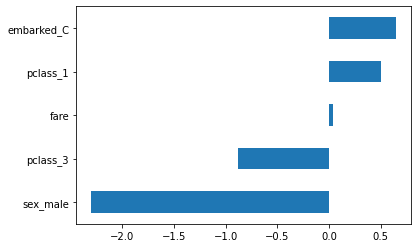

In [14]:
import pandas as pd

log_reg = clf[-1]
coef = pd.Series(log_reg.coef_.ravel(), index=log_reg.feature_names_in_)
_ = coef.sort_values().plot.barh()

This resets `transform_output` to its default value to avoid impacting other
examples when generating the scikit-learn documentation



In [15]:
set_config(transform_output="default")

When configuring the output type with :func:`config_context` the
configuration at the time when `transform` or `fit_transform` are
called is what counts. Setting these only when you construct or fit
the transformer has no effect.



In [16]:
from sklearn import config_context

scaler = StandardScaler()
scaler.fit(X_train[num_cols])

StandardScaler()

In [17]:
with config_context(transform_output="pandas"):
    # the output of transform will be a Pandas DataFrame
    X_test_scaled = scaler.transform(X_test[num_cols])
X_test_scaled.head()

,age,fare
11,-0.828276,3.759535
1147,-0.549971,0.127120
865,NaN,-0.490490
860,-0.271667,-0.487106
1172,NaN,0.704603


outside of the context manager, the output will be a NumPy array



In [18]:
X_test_scaled = scaler.transform(X_test[num_cols])
X_test_scaled[:5]

array([[-0.82827555,  3.75953504],
       [-0.54997108,  0.12711996],
       [        nan, -0.49048971],
       [-0.2716666 , -0.48710555],
       [        nan,  0.70460313]])